In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.DataFrame()
             
# our method
df_buffer = pd.read_csv(f'../results/warfarin/compiled/unconstrained_agg.csv')
df_buffer['method'] = df_buffer['method'].map({'Direct': 'DM', 'Robust': 'DR', 'IPW': 'IPW'})
df_buffer1 = df_buffer[(df_buffer['method'].isin(['DM', 'IPW'])) & (df_buffer['depth'] == 2)]
df_buffer2 = df_buffer[(df_buffer['method'] == 'DR') & (df_buffer['depth'] > 1)]
df_buffer2['method'] = df_buffer2.apply(lambda row: f'DR (d={row["depth"]})', axis=1)

df = pd.concat([df, df_buffer1[['method', 'gap', 'solve_time']], df_buffer2[['method', 'gap', 'solve_time']]], ignore_index=True)

# kallus bertsimas
df_buffer = pd.read_csv(f'../results/warfarin/compiled/KB.csv')
df_buffer['method'] = df_buffer['method'].map({'Kallus': 'K-PT', 'Bertsimas': 'B-PT'})
df = pd.concat([df, df_buffer[['method', 'gap', 'solve_time']]], ignore_index=True)

# policytree
df_buffer = pd.read_csv(f'../results/warfarin/compiled/policytree/raw_proba.csv')
for col, name in zip(['random_time', 'r0.06_time', 'r0.11_time'], ['0.33', 'r0.06', 'r0.11']):
    h = pd.DataFrame({'solve_time': df_buffer[col].tolist()})
    h['method'] = 'PT'
    h['gap'] = 0
    df = pd.concat([df, h], ignore_index=False)

# CF, CT
for m, m_name in zip(['cf', 'cf_untuned', 'ct'], ['CF', 'CF (untuned)', 'CT']):
    df_buffer = pd.read_csv(f'../results/warfarin/compiled/CF/{m}_baseline_raw.csv')
#     df_trans = pd.DataFrame(columns=['method', 'randomization', 'realized_outcome_oos'])
    for col, name in zip(['time_random', 'time_r0.06', 'time_r0.11'], ['0.33', 'r0.06', 'r0.11']):
        h = pd.DataFrame({'solve_time': df_buffer[col].tolist()})
        h['method'] = m_name
        h['gap'] = 0
        df = pd.concat([df, h], ignore_index=False)
        
        
import pickle
with open('../results/warfarin/compiled/RC/rc_warfarin_times.p', 'rb') as f:
    times = pickle.load(f)
    
h = pd.DataFrame({'solve_time': times})
h['gap'] = 0
h['method'] = 'RC'
df = pd.concat([df, h], ignore_index=False)

In [3]:
warfarin_solve = df[df['solve_time'] <= 14400]
warfarin_gap = df[(df['solve_time'] > 14400) & (np.isfinite(df['gap']))]
warfarin_gap_100 = df[df['gap'] <= 100]
warfarin_gap_inf = df[(df['solve_time'] > 14400) & (~np.isfinite(df['gap']))]

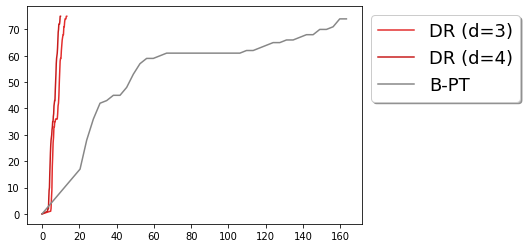

In [59]:
colors ={"IPW": "#FFC7C7", "DM": "#FFA4A4", "DR (d=2)": "#EB6262", "DR (d=3)": "#E32D2D", "DR (d=4)": "#C81C1C", 
         "K-PT": "#BFBFBF", "B-PT": "#878787"}

for method in ['DR (d=3)', 'DR (d=4)', 'B-PT']:
    values1, base1 = np.histogram(warfarin_gap[warfarin_gap['method'] == method]['gap'], bins=40)
    cumulative1 = np.cumsum(values1)
    int_max1 = cumulative1[-1]
    cumulative1 = np.append(cumulative1, int_max1)
    
    cumulative1 = np.insert(cumulative1, 0, 0, axis=0)
    base1 = np.insert(base1, 0, 0, axis=0)

#     matplotlib.rcParams['mathtext.fontset'] = 'stix'
#     matplotlib.rcParams['font.family'] = 'STIXGeneral'
    plt.plot(base1, cumulative1, c=colors[method], label=method)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fancybox=True, shadow=True, prop={'size': 18})

In [77]:
df['method'].value_counts()

RC              75
CF              75
K-PT            75
CT              75
PT              75
DR (d=4)        75
DR (d=3)        75
DR (d=2)        75
B-PT            75
IPW             75
DM              75
CF (untuned)    75
Name: method, dtype: int64

In [ ]:
colors = ["#FFC7C7", "#FFA4A4", "#EB6262", "#E32D2D", "#C81C1C",
         "#BFBFBF", "#878787",
         "#9CCF9B", "#67D165", "#21C51D",
          "#CCDA2F",
         "#B1B0CD", "#7B79CF", "#4543C0"]

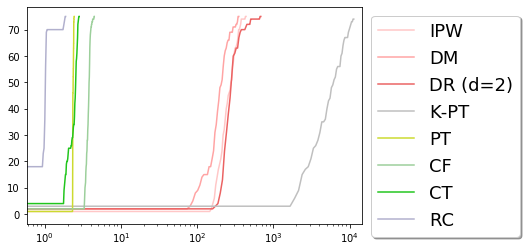

In [87]:
colors ={"IPW": "#FFC7C7", "DM": "#FFA4A4", "DR (d=2)": "#EB6262", "DR (d=3)": "#E32D2D", "DR (d=4)": "#C81C1C", 
         "K-PT": "#BFBFBF", "B-PT": "#878787", 'PT': "#CCDA2F", 'CF': "#9CCF9B", 'CT': "#21C51D", 'RC': '#B1B0CD'}
for method in ['IPW', 'DM', 'DR (d=2)', 'K-PT', 'PT', 'CF', 'CT', 'RC']:
    # ax2 = ax.twiny()
    values, base = np.histogram(warfarin_solve[warfarin_solve['method'] == method]['solve_time'], bins=40)
    cumulative = np.cumsum(values)
    int_max = cumulative[-1]
    cumulative = np.insert(cumulative, 0, 0, axis=0)
    cumulative = np.append(cumulative, int_max)
    base = np.insert(base, 0, 0, axis=0)

    plt.plot(base, cumulative, c=colors[method], label=method)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fancybox=True, shadow=True, prop={'size': 18})
plt.xscale("log")
plt.xlim([-100, 14400])
plt.show()

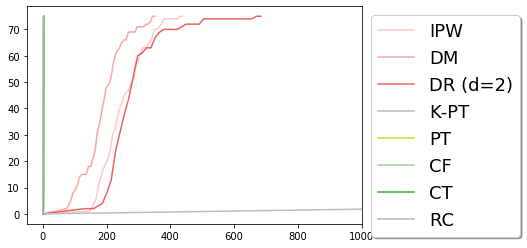

In [84]:
colors ={"IPW": "#FFC7C7", "DM": "#FFA4A4", "DR (d=2)": "#EB6262", "DR (d=3)": "#E32D2D", "DR (d=4)": "#C81C1C", 
         "K-PT": "#BFBFBF", "B-PT": "#878787", 'PT': "#CCDA2F", 'CF': "#9CCF9B", 'CT': "#21C51D", 'RC': '#B1B0CD'}
for method in ['IPW', 'DM', 'DR (d=2)', 'K-PT', 'PT', 'CF', 'CT', 'RC']:
    # ax2 = ax.twiny()
    values, base = np.histogram(warfarin_solve[warfarin_solve['method'] == method]['solve_time'], bins=40)
    cumulative = np.cumsum(values)
    int_max = cumulative[-1]
    cumulative = np.insert(cumulative, 0, 0, axis=0)
    cumulative = np.append(cumulative, int_max)
    base = np.insert(base, 0, 0, axis=0)

    plt.plot(base, cumulative, c=colors[method], label=method)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fancybox=True, shadow=True, prop={'size': 18})
plt.xlim([-50, 1000])
plt.show()

In [4]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
colors ={"IPW": "#FFC7C7", "DM": "#FFA4A4", r"DR ($d=2$)": "#EB6262", r"DR ($d=3$)": "#E32D2D", r"DR ($d=4$)": "#C81C1C", 
         "K-PT": "#BFBFBF", "B-PT": "#878787", 'PT': "#CCDA2F", 'CF': "#9CCF9B", 'CT': "#21C51D", 'R&C (Best)': '#B1B0CD'}
legend_elements = [Line2D([0], [0], color=v, lw=3, linestyle='-', label=k) for k, v in colors.items()]

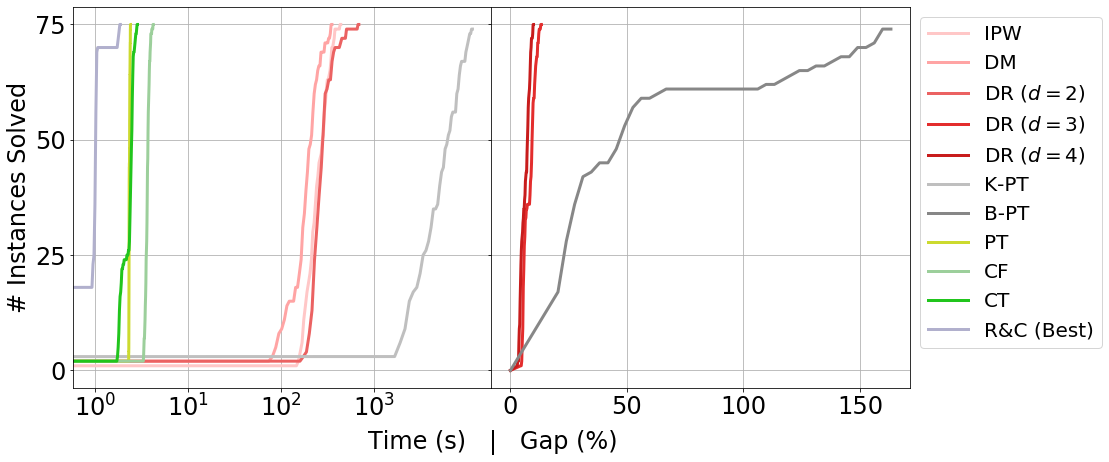

In [5]:
matplotlib.rcParams.update({'font.size': 24})
colors ={"IPW": "#FFC7C7", "DM": "#FFA4A4", "DR (d=2)": "#EB6262", "DR (d=3)": "#E32D2D", "DR (d=4)": "#C81C1C", 
         "K-PT": "#BFBFBF", "B-PT": "#878787", 'PT': "#CCDA2F", 'CF': "#9CCF9B", 'CT': "#21C51D", 'RC': '#B1B0CD'}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharey=True)
for i in range(2):
    if i == 0:
        for method in ['IPW', 'DM', 'DR (d=2)', 'K-PT', 'PT', 'CF', 'CT', 'RC']:
            # ax2 = ax.twiny()
            values, base = np.histogram(warfarin_solve[warfarin_solve['method'] == method]['solve_time'], bins=40)
            cumulative = np.cumsum(values)
            int_max = cumulative[-1]
            cumulative = np.insert(cumulative, 0, 0, axis=0)
            cumulative = np.append(cumulative, int_max)
            base = np.insert(base, 0, 0, axis=0)

            ax[i].plot(base, cumulative, c=colors[method], label=method, linewidth=3)
            ax[i].set_xscale("log")
            ax[i].set_xticks([1, 10, 100, 1000])
            ax[i].set_yticks([0, 25, 50, 75])
#             ax[i].set_xlabel('Time (s)', horizontalalignment='right', x=0.9)
            ax[i].set_ylabel('# Instances Solved')
            ax[i].grid(True)
            
    else:
        for method in ['DR (d=3)', 'DR (d=4)', 'B-PT']:
            values1, base1 = np.histogram(warfarin_gap[warfarin_gap['method'] == method]['gap'], bins=40)
            cumulative1 = np.cumsum(values1)

            cumulative1 = np.insert(cumulative1, 0, 0, axis=0)
            int_max1 = cumulative1[-1]
            cumulative1 = np.append(cumulative1, int_max1)
            base1 = np.insert(base1, 0, 0, axis=0)
            ax[i].plot(base1, cumulative1, c=colors[method], label=method, linewidth=3)
#             ax[i].set_xlabel('Gap')
            ax[i].legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), prop={'size': 20}, ncol=1)
#             ax[i].margins(x=0.0)
            ax[i].grid()
    
plt.text(-61, -17, 'Time (s)   |   Gap (%)')

# plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), fancybox=True, shadow=True, prop={'size': 18})
plt.subplots_adjust(wspace=0)
plt.savefig('figs/warfarin_comp_times.pdf', bbox_inches='tight')
plt.show()

In [47]:
df = pd.DataFrame()
             
# our method
df_buffer = pd.read_csv(f'../results/synthetic/compiled/our_method.csv')

df_buffer = df_buffer[((df_buffer['method'] == 'IPW') & (df_buffer['prop_pred'] == 'tree')) |\
                     ((df_buffer['method'] == 'Direct') & (df_buffer['ml'] == 'linear')) |\
                     ((df_buffer['method'] == 'Robust') & (df_buffer['prop_pred'] == 'tree') & (df_buffer['ml'] == 'linear'))]

df_buffer = df_buffer[((df_buffer['budget'].isna()) | (df_buffer['budget'] == 1)) & (df_buffer['depth'] == 1)]

df_buffer['method'] = df_buffer['method'].map({'Direct': 'DM', 'Robust': 'DR', 'IPW': 'IPW'})
df = pd.concat([df, df_buffer[['method', 'gap', 'solve_time']]], ignore_index=True)


# kallus bertsimas
df_buffer = pd.read_csv(f'../results/synthetic/compiled/KB.csv')
df_buffer['method'] = df_buffer['method'].map({'Kallus': 'K-PT', 'Bertsimas': 'B-PT'})
df = pd.concat([df, df_buffer[['method', 'gap', 'solve_time']]], ignore_index=True)

# policytree
df_buffer = pd.read_csv(f'../results/synthetic/compiled/policytree/raw.csv')
for col, name in zip(['time_0.1', 'time_0.25', 'time_0.5', 'time_0.75', 'time_0.9'], ['0.1', '0.25', '0.5', '0.75', '0.9']):
    h = pd.DataFrame({'solve_time': df_buffer[col].tolist()})
    h['method'] = 'PT'
    h['gap'] = 0
    df = pd.concat([df, h], ignore_index=False)

# CF, CT
for m, m_name in zip(['cf', 'ct'], ['CF', 'CT']):
    df_buffer = pd.read_csv(f'../results/synthetic/compiled/CF/{m}_raw.csv')
    for col, name in zip(['time_0.1', 'time_0.25', 'time_0.5', 'time_0.75', 'time_0.9'], ['0.1', '0.25', '0.5', '0.75', '0.9']):
        h = pd.DataFrame({'solve_time': df_buffer[col].tolist()})
        h['method'] = m_name
        h['gap'] = 0
        df = pd.concat([df, h], ignore_index=False)
        
# rc
fp = '../results/synthetic/compiled/RC'
df_buffer = pd.read_csv(os.path.join(fp, 'raw.csv'))
df_buffer = df_buffer[df_buffer['method'] == 'lr']
df_buffer['method'] = 'RC'
df_buffer = df_buffer.rename(columns={'time_elapsed': 'solve_time'})
df_buffer['gap'] = 0
df = pd.concat([df, df_buffer[['method', 'gap', 'solve_time']]], ignore_index=False)

In [49]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
colors ={"IPW (DT)": "#FFC7C7", "DM (LR)": "#FFA4A4", "DR (LR, DT)": "#EB6262",
         "K-PT": "#BFBFBF", "B-PT": "#878787", 'PT': "#CCDA2F", 'CF': "#9CCF9B", 'CT': "#21C51D", 'R&C (LR)': '#B1B0CD'}
legend_elements = [Line2D([0], [0], color=v, lw=2, linestyle='-', label=k) for k, v in colors.items()]

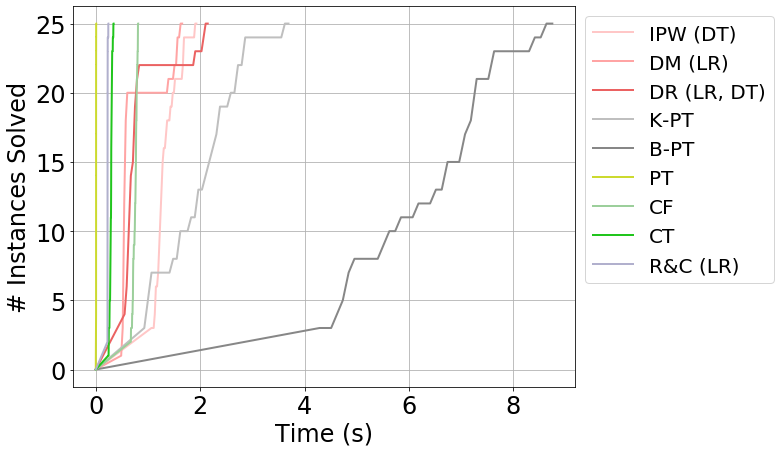

In [51]:
matplotlib.rcParams.update({'font.size': 24})
colors ={"IPW": "#FFC7C7", "DM": "#FFA4A4", "DR": "#EB6262", 
         "K-PT": "#BFBFBF", "B-PT": "#878787", 'PT': "#CCDA2F", 'CF': "#9CCF9B", 'CT': "#21C51D", 'RC': '#B1B0CD'}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7), sharey=True)
for method in ['IPW', 'DM', 'DR', 'K-PT', 'B-PT', 'PT', 'CF', 'CT', 'RC']:
#                'PT', 'CF', 'CT', 'RC']:
    # ax2 = ax.twiny()
    values, base = np.histogram(df[df['method'] == method]['solve_time'], bins=40)
    cumulative = np.cumsum(values)
    int_max = cumulative[-1]
    cumulative = np.insert(cumulative, 0, 0, axis=0)
    cumulative = np.append(cumulative, int_max)
    base = np.insert(base, 0, 0, axis=0)

    ax.plot(base, cumulative, c=colors[method], label=method, linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('# Instances Solved')
#     ax.grid()
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1.0), prop={'size': 20}, ncol=1)
plt.grid(True)
# plt.savefig('figs/synthetic_comp_times.pdf', bbox_inches='tight')
plt.show()

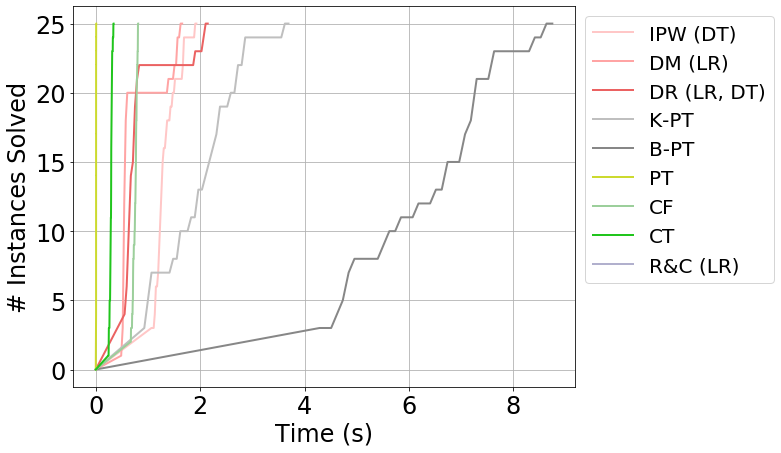

In [55]:
matplotlib.rcParams.update({'font.size': 24})
colors ={"IPW": "#FFC7C7", "DM": "#FFA4A4", "DR": "#EB6262", 
         "K-PT": "#BFBFBF", "B-PT": "#878787", 'PT': "#CCDA2F", 'CF': "#9CCF9B", 'CT': "#21C51D", 'RC': '#B1B0CD'}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7), sharey=True)
for method in ['IPW', 'DM', 'DR', 'K-PT', 'B-PT', 'PT', 'CF', 'CT']:
#                'PT', 'CF', 'CT', 'RC']:
    # ax2 = ax.twiny()
    values, base = np.histogram(df[df['method'] == method]['solve_time'], bins=40)
    cumulative = np.cumsum(values)
    int_max = cumulative[-1]
    cumulative = np.insert(cumulative, 0, 0, axis=0)
    cumulative = np.append(cumulative, int_max)
    base = np.insert(base, 0, 0, axis=0)

    ax.plot(base, cumulative, c=colors[method], label=method, linewidth=2)
#     ax[i].set_xscale("log")
#     ax[i].set_xticks([1, 10, 100, 1000])
#     ax[i].set_yticks([0, 25, 50, 75])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('# Instances Solved')
#     ax.grid()
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1.0), prop={'size': 20}, ncol=1)
plt.grid(True)
# plt.savefig('figs/synthetic_comp_times.pdf', bbox_inches='tight')
plt.show()